Higgs boson (God Particle) is a fundamental particle that's responsible for the *mass* of matter. First theorized in the 1964, the Higgs boson eluded observation for almost fifty years. In 2012 it was finally observed experimentally at the Large Hadron Collider. These experiments produced millions of gigabytes of data.

In this notebook, i'll use TPUs to build a Wide and Deep neural network to determine whether an observed particle collision produced a Higgs boson or not. 

A Wide and Deep neural network trains a linear layer side-by-side with a deep stack of dense layers. They're the main choise for tabular datasets. 

In [ ]:
# !pip install -q --force-reinstall --no-cache-dir \
#     "tensorflow==2.13.1" "keras==2.13.1" "protobuf<4" "numpy==1.24.3"

# # Immediately restart the notebook’s Python kernel so it reloads the new wheel
# import os, signal
# os.kill(os.getpid(), 9)          # Kaggle will auto-restart the cell

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Ver:' + tf.__version__)

# Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

from kaggle_datasets import KaggleDatasets
from tensorflow.io import FixedLenFeature
AUTO = tf.data.experimental.AUTOTUNE

# detect & set up TPU, otherwise,default to GPU/CPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local') # detect TPU uto-detect
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ Running on TPU")
except (ValueError, tf.errors.NotFoundError):
    strategy = tf.distribute.get_strategy()  # CPU / single GPU
    print("✅ Running on CPU/GPU")

tpu_strategy = tf.distribute.TPUStrategy(resolver)
print('TPU connected')

    
print("num accelerators: ", strategy.num_replicas_in_sync)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


E0000 00:00:1749432732.384769    5549 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Tensorflow Ver:2.18.0
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1749432737.873458    5549 service.cc:148] XLA service 0x5b2e8a0fee20 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749432737.873502    5549 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1749432737.873506    5549 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1749432737.873509    5549 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1749432737.873512    5549 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1749432737.873515    5549 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1749432737.873517    5549 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1749432737.873520    5549 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1749432737.873523    5549 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

**Loading Data**:

The following function will parse the TFRecords & build a tensorflow `tf.data.Dataset` obj that we use for training. This is because the dataset is encoded in a binary file format called *TFREcords*. 

In [3]:
def make_decoder(feature_description):
    def decoder(example):
        example  = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])

        label = example['label']
        label = tf.expand_dims(label, -1)   # shape (1,)  -> (1,1)

        return features, label
    return decoder


def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset



In [4]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256

In [5]:
import os

print("=== /kaggle/input contents ===")
for entry in os.listdir("/kaggle/input"):
    print("  •", entry)


=== /kaggle/input contents ===
  • higgs-boson-dataset


In [5]:
import os
import random
feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)
data_dir = KaggleDatasets().get_gcs_path('higgs-boson-dataset')
print(tf.io.gfile.listdir(data_dir))

all_files = tf.io.gfile.glob(os.path.join(data_dir, "*.tfrecord"))
all_files = sorted(all_files)        
random.shuffle(all_files)
split = int(0.8 * len(all_files))
train_files = all_files[:split]
valid_files = all_files[split:]


print("Found", len(train_files), "train TFRecords")
print("Found", len(valid_files), "valid TFRecords")

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .shuffle(2 ** 19)
    .repeat()
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    # .repeat()
    .cache()
    .prefetch(AUTO)
)



get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/higgs-boson-dataset


['shard_21.tfrecord', 'shard_22.tfrecord', 'shard_14.tfrecord', 'shard_02.tfrecord', 'shard_03.tfrecord', 'shard_23.tfrecord', 'shard_09.tfrecord', 'shard_01.tfrecord', 'shard_15.tfrecord', 'shard_04.tfrecord', 'shard_13.tfrecord', 'shard_05.tfrecord', 'shard_00.tfrecord', 'shard_07.tfrecord', 'shard_11.tfrecord', 'shard_10.tfrecord', 'shard_17.tfrecord', 'shard_12.tfrecord', 'shard_08.tfrecord', 'shard_19.tfrecord', 'shard_16.tfrecord', 'shard_06.tfrecord', 'shard_18.tfrecord', 'shard_20.tfrecord']
Found 19 train TFRecords
Found 5 valid TFRecords


**Model Training**:

Using Keras *Functional API* (not the *Sequential API*), I define the network. I'm defining the deep branch of the network using the Functional API


In [6]:



from tensorflow.keras import layers

UNITS       = 128
ACTIVATION  = "relu"
DROPOUT     = 0.3

def dense_block(units, activation, dropout_rate):
    def make(x):
        x = layers.Dense(units)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # ---------- inputs ----------
    inputs = keras.Input(shape=[28], name="feat")

    # ---------- wide branch ----------
    wide_logits = layers.Dense(1, activation=None)(inputs)

    # ---------- deep branch ----------
    x = inputs
    for _ in range(5):
        x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    deep_logits = layers.Dense(1, activation=None)(x)

    # ---------- combine branches ----------
    logits = layers.Add(name="add_logits")([wide_logits, deep_logits])   # <-- raw logits, no sigmoid
    wide_and_deep  = keras.Model(inputs, logits)

    # ---------- compile: tell Keras these are logits ----------
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    wide_and_deep.compile(
        optimizer = optimizer,
        loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics   = [
            tf.keras.metrics.AUC(name="AUC", from_logits=True),
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.0),
        ],
    )


wide_and_deep.summary()




I0000 00:00:1749432757.374012    5549 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feat (InputLayer)   │ (None, 28)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      3,712 │ feat[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ dense_5[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         29 │ feat[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_logits (Add)    │ (None, 1)         │          0 │ dense[0][0],      │
│                     │                   │            │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,918 (273.12 KB)

 Trainable params: 69,918 (273.12 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# import tensorflow as tf
# tf.debugging.enable_check_numerics()          # crash as soon as NaN / Inf appears

# print("Running one debug batch …")
# feats, lbls = next(iter(ds_train))            # grab one batch
# loss = wide_and_deep.train_on_batch(          # forward + back-prop
#     feats,
#     lbls,
#     return_dict=False                         # just scalar loss
#  )
# print("✓ Batch finished, loss =", loss)


Training:

For training, I'll use the `EarlyStopping` callback, which tracks when the MAE stops decreasing and starts increasing, at which point it'll stop the training. This prevents Underfitting & Overfitting.

Notice that i've defined a learning rate schedule. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by 0.2 if the validation loss didn't decrease after an epoch.

In [7]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)
print("Train batches per epoch:", steps_per_epoch)
print("Actual batches in ds_train:", sum(1 for _ in ds_train.take(steps_per_epoch+5)))

print("Number of train files:", len(train_files))
print(train_files[:5])          # peek

history = wide_and_deep.fit(
    ds_train,
    validation_data = ds_valid,
    epochs          = 50,
    steps_per_epoch = steps_per_epoch,      # 640 in your case
    validation_steps= validation_steps,     # 80 in your case
    callbacks       = [early_stopping, lr_schedule],
)

Train batches per epoch: 640
Actual batches in ds_train: 645
Number of train files: 19
['/kaggle/input/higgs-boson-dataset/shard_15.tfrecord', '/kaggle/input/higgs-boson-dataset/shard_07.tfrecord', '/kaggle/input/higgs-boson-dataset/shard_23.tfrecord', '/kaggle/input/higgs-boson-dataset/shard_04.tfrecord', '/kaggle/input/higgs-boson-dataset/shard_03.tfrecord']
Epoch 1/50


I0000 00:00:1749432987.958161    5549 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12322787700806472589
I0000 00:00:1749432991.339906    6364 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15429802664778617777), session_name()
I0000 00:00:1749432996.686688    6364 tpu_compile_op_common.cc:245] Compilation of 15429802664778617777 with session name  took 5.346736343s and succeeded
I0000 00:00:1749432996.723117    6364 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15429802664778617777), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_12322787700806472589", property.function_library_fingerprint = 3438483846403870014, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: nan - binary_accuracy: nan - loss: nan

I0000 00:00:1749433030.769709    5549 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1030380417345330254
I0000 00:00:1749433031.317617    6306 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16354189497699909715), session_name()
I0000 00:00:1749433031.996824    6306 tpu_compile_op_common.cc:245] Compilation of 16354189497699909715 with session name  took 679.105924ms and succeeded
I0000 00:00:1749433031.999417    6306 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16354189497699909715), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_1030380417345330254", property.function_library_fingerprint = 3989223752335880440, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

640/640 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.6553 - val_binary_accuracy: 0.6145 - val_loss: 0.6530 - learning_rate: 1.0000e-04
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.6812 - val_binary_accuracy: 0.6318 - val_loss: 0.6411 - learning_rate: 1.0000e-04
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.7383 - val_binary_accuracy: 0.6661 - val_loss: 0.6080 - learning_rate: 1.0000e-04
Epoch 5/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.7533 - val_binary_accuracy: 0.6817 - val_loss: 0.5942 - learning_rate: 1.0000e-04
Epoch 6/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.7642 - val_binary_accuracy: 0.6902 - val_loss: 0.5837 - learning_rate: 1.0000e-04
Epoch 7/50
640/640 ━━━━━━━━━━━━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



640/640 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.8122 - val_binary_accuracy: 0.7310 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 21/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.8131 - val_binary_accuracy: 0.7332 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 22/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.8138 - val_binary_accuracy: 0.7316 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 23/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.8152 - val_binary_accuracy: 0.7332 - val_loss: 0.5302 - learning_rate: 1.0000e-04
Epoch 24/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - AUC: nan - binary_accuracy: nan - loss: nan - val_AUC: 0.8158 - val_binary_accuracy: 0.7346 - val_loss: 0.5291 - learning_rate: 1.0000e-04
Epoch 25/50
640/640 ━━━━━━━━━━━━

dict_keys(['AUC', 'binary_accuracy', 'loss', 'val_AUC', 'val_binary_accuracy', 'val_loss', 'learning_rate'])
{'verbose': 'auto', 'epochs': 50, 'steps': 640}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
{'AUC': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'binary_accuracy': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'val_AUC': [0.6552883386611938, 0.6811650395393372, 0.7127602100372314, 0.7383219003677368, 0.7532946467399597, 0.7641927599906921, 0.7738745212554932, 0.7813698649406433, 0.7863469123840332, 0.7910669445991516, 0.794654130935669, 0.7974018454551697, 0.7995105

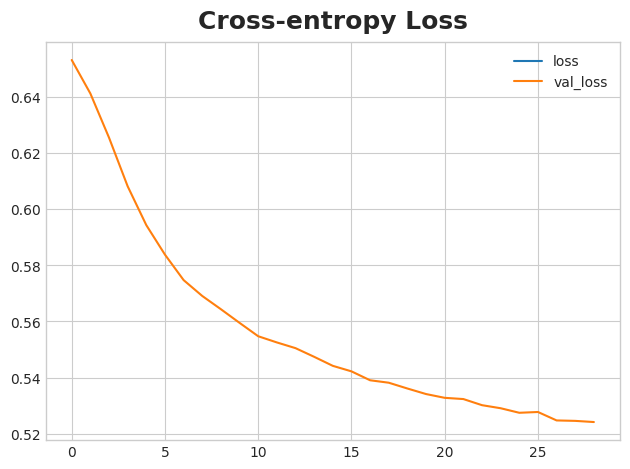

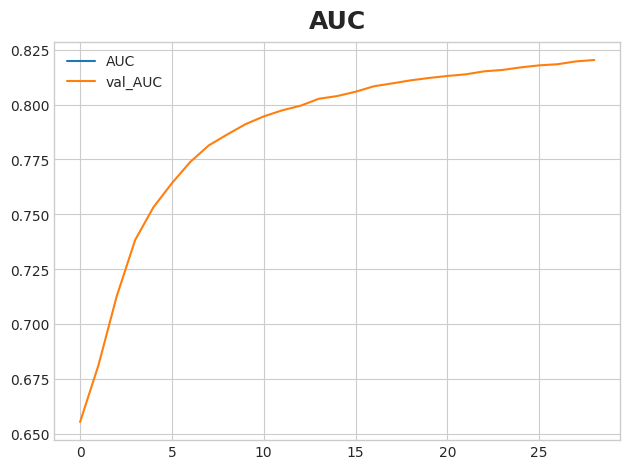

In [8]:
history_frame = pd.DataFrame(history.history)

print(history.history.keys())
print(history.params)                  # epochs, steps per epoch, etc.
print(history.epoch)                   # list of finished epochs
print(history.history)                 # dictionary of lists
print(history_frame.head())

# chatGPT debugging
for feat, lbl in ds_train.take(1):
    print("features dtype:", feat.dtype, "min/max:", tf.reduce_min(feat).numpy(), tf.reduce_max(feat).numpy())
    print("any NaN in features? ", tf.math.reduce_any(tf.math.is_nan(feat)).numpy())
    print("labels  dtype:", lbl.dtype, "unique:", tf.unique(tf.reshape(lbl, [-1]))[0].numpy()[:10])
    break

tmp_out = wide_and_deep(feat, training=True)
print("Output logits / probs  (first 10):", tmp_out[:10].numpy())
print("any NaN in output? ", tf.math.reduce_any(tf.math.is_nan(tmp_out)).numpy())

print("Min/Max label values:", lbl.numpy().min(), lbl.numpy().max())



history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['AUC', 'val_AUC']].plot(title='AUC');